In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm
from statsmodels.formula.api import ols

## Loading and Understanding the Data

In [25]:
data = pd.read_csv('healthcare_dataset.csv', delimiter=',', encoding='ISO-8859-1')
data = data.drop(columns=['Name', 'Doctor', 'Hospital'])
data = data.dropna().drop_duplicates()
data.columns

Index(['Age', 'Gender', 'Blood Type', 'Medical Condition', 'Date of Admission',
       'Insurance Provider', 'Billing Amount', 'Room Number', 'Admission Type',
       'Discharge Date', 'Medication', 'Test Results'],
      dtype='object')

In [26]:
print(f'\n{data.info()}\n, \n{data.describe()}, \n{data.isnull().sum()}')

<class 'pandas.core.frame.DataFrame'>
Index: 54966 entries, 0 to 55499
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 54966 non-null  int64  
 1   Gender              54966 non-null  object 
 2   Blood Type          54966 non-null  object 
 3   Medical Condition   54966 non-null  object 
 4   Date of Admission   54966 non-null  object 
 5   Insurance Provider  54966 non-null  object 
 6   Billing Amount      54966 non-null  float64
 7   Room Number         54966 non-null  int64  
 8   Admission Type      54966 non-null  object 
 9   Discharge Date      54966 non-null  object 
 10  Medication          54966 non-null  object 
 11  Test Results        54966 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 5.5+ MB

None
, 
                Age  Billing Amount   Room Number
count  54966.000000    54966.000000  54966.000000
mean      51.535185    25544.306284    

In [27]:
data['Date of Admission'] = pd.to_datetime(data['Date of Admission'])
data['Discharge Date'] = pd.to_datetime(data['Discharge Date'])
data['Length of Stay'] = (data['Discharge Date'] - data['Date of Admission']).dt.days
data = data.drop(['Date of Admission', 'Discharge Date'], axis=1)

Distribution of Categorical Variables

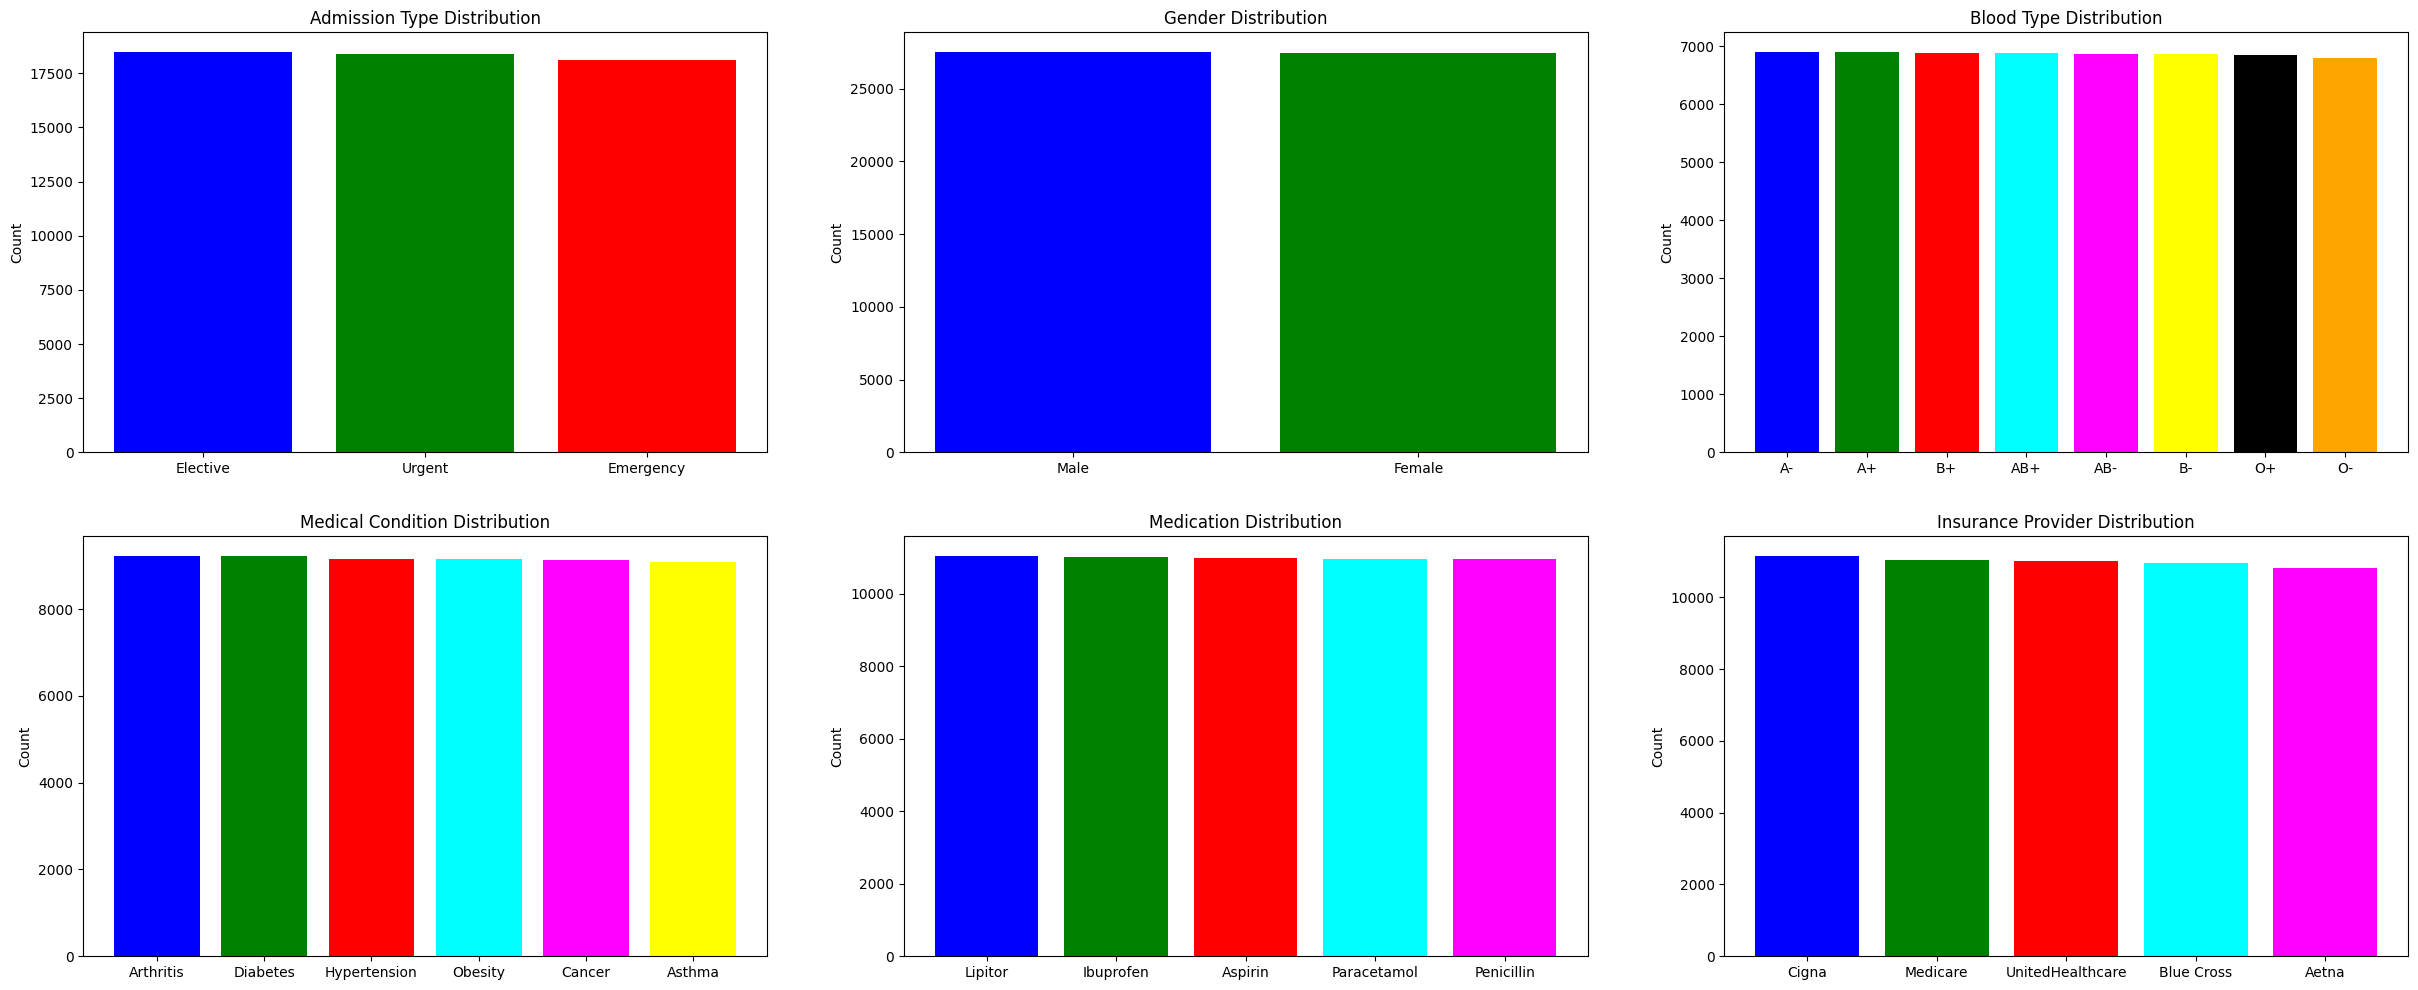

In [28]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(30, 12))

colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange']
variables = ['Admission Type', 'Gender', 'Blood Type', 'Medical Condition', 'Medication', 'Insurance Provider', 'Test Results']
for ax, var in zip(axs.flatten(), variables):
    counts = data[var].value_counts()
    ax.bar(counts.index, counts.values, color=colors)
    ax.set_title(f'{var} Distribution')
    ax.set_ylabel('Count')

Distribution of Target Variable

([<matplotlib.patches.Wedge at 0x163c06300>,
 [Text(-1.0780378833580209, -0.40041768448079174, 'Abnormal'),
  Text(0.8909663517814893, -0.7271031288566868, 'Normal'),
  Text(0.19166408075951005, 1.1339157288558142, 'Inconclusive')],
 [Text(-0.6093257601588813, -0.2263230390543605, '33.5%'),
  Text(0.5035896770938852, -0.4109713337016056, '33.3%'),
  Text(0.1083318717336361, 0.6409088902228514, '33.1%')])

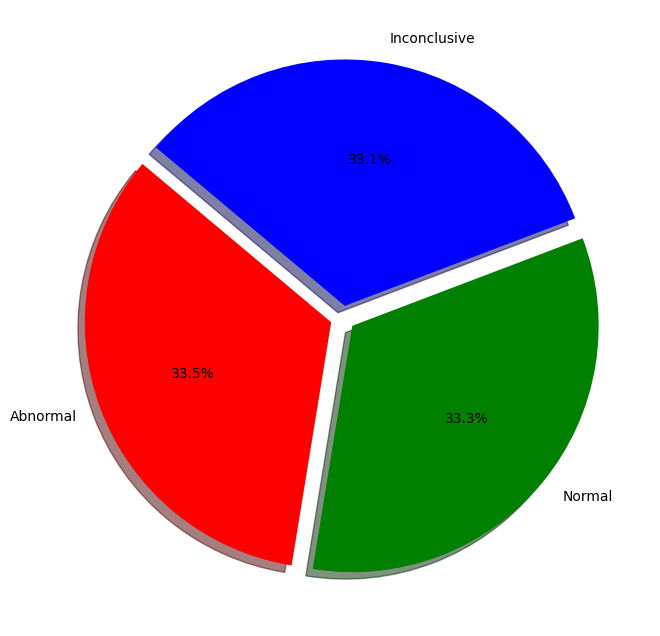

In [29]:
Test_Results_counts = data['Test Results'].value_counts()
df_Test_Results = pd.DataFrame({'Label':Test_Results_counts.index, 'Counts':Test_Results_counts.values})
plt.figure(figsize=(8, 8))
explode = [0.05] * len(df_Test_Results) 
colors = ['red', 'green', 'blue']  

plt.pie(df_Test_Results['Counts'], explode=explode, colors=colors[:len(df_Test_Results)], 
        labels=df_Test_Results['Label'], autopct='%1.1f%%', shadow=True, startangle=140)

Distribution of Numerical Variables

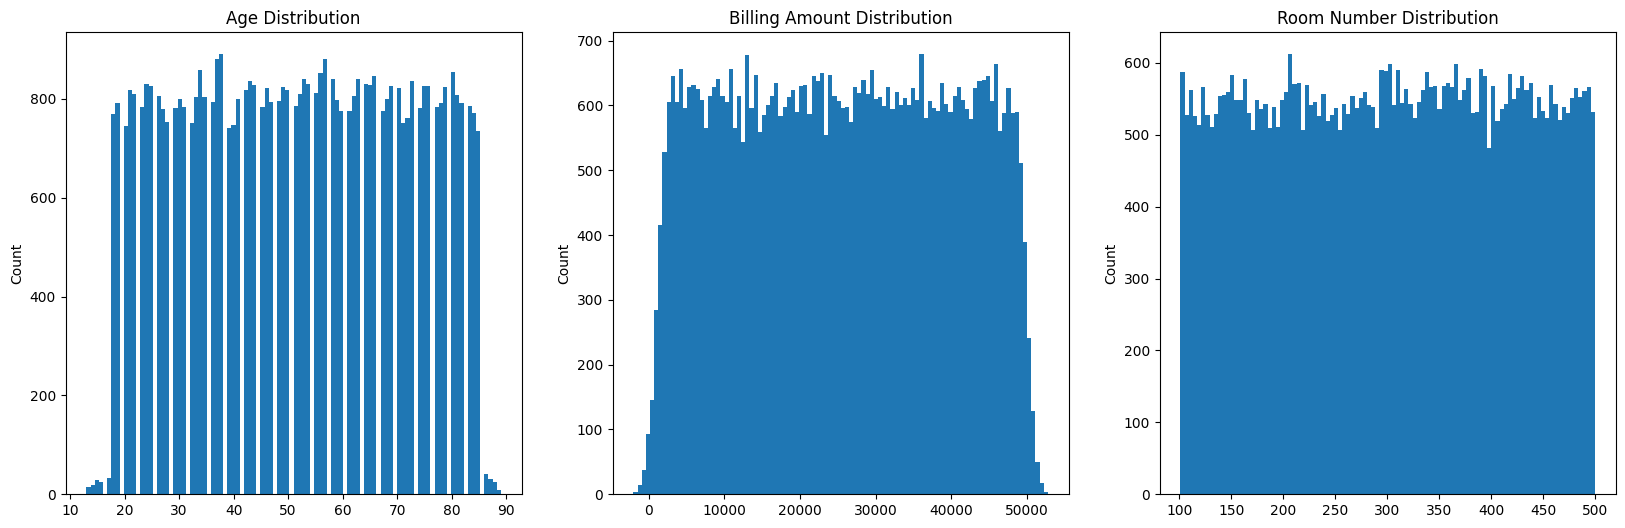

In [30]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

variables = ['Age', 'Billing Amount', 'Room Number']
for ax, var in zip(axs.flatten(), variables):
    ax.hist(data[var], 100)
    ax.set_title(f'{var} Distribution')
    ax.set_ylabel('Count')

## Exploratory Data Analysis (EDA)

Chi-Square test for categorical variables

In [31]:
categorical_cols = data.drop(columns=['Room Number', 'Billing Amount','Test Results','Age','Length of Stay'])

chi2_results = []
for feature in categorical_cols:
    contingency_table = pd.crosstab(data[feature], data['Test Results'])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    chi2_results.append((feature, chi2, p))

chi2_df = pd.DataFrame(chi2_results, columns=['Feature', 'Chi-Square', 'P-Value'])
chi2_df.sort_values(by='P-Value', inplace=True)
print(f'Chi-Square test: \n{chi2_df}')

Chi-Square test: 
              Feature  Chi-Square   P-Value
2   Medical Condition   13.271595  0.208881
0              Gender    2.184632  0.335439
3  Insurance Provider    9.034619  0.339384
4      Admission Type    1.648354  0.800076
5          Medication    3.851882  0.870234
1          Blood Type    8.001800  0.889232


In [32]:
low_cardinality_cols = ['Gender', 'Blood Type', 'Medical Condition', 'Admission Type', 'Medication']
high_cardinality_cols = ['Insurance Provider']

encoder = OneHotEncoder()
low_cardinality_cols_encoded = {}
encoder_names = []
for col in data[low_cardinality_cols]:
    low_cardinality_cols_encoded[col] = encoder.fit_transform(data[[col]]).toarray()
    encoder_names.extend(encoder.categories_)
column_names = [name for names in encoder_names for name in names]
encoded_arrays = [low_cardinality_cols_encoded[col] for col in low_cardinality_cols]
encoded_data = np.hstack(encoded_arrays)
encoded_df = pd.DataFrame(encoded_data, columns=column_names)

In [33]:
label_encoders = {}
for col in high_cardinality_cols:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col])

In [34]:
Cleaned_data = pd.concat([data.drop(columns=low_cardinality_cols), encoded_df ], axis=1).dropna()
Cleaned_data.columns

Index(['Age', 'Insurance Provider', 'Billing Amount', 'Room Number',
       'Test Results', 'Length of Stay', 'Female', 'Male', 'A+', 'A-', 'AB+',
       'AB-', 'B+', 'B-', 'O+', 'O-', 'Arthritis', 'Asthma', 'Cancer',
       'Diabetes', 'Hypertension', 'Obesity', 'Elective', 'Emergency',
       'Urgent', 'Aspirin', 'Ibuprofen', 'Lipitor', 'Paracetamol',
       'Penicillin'],
      dtype='object')

In [35]:
column_to_rename = {'Test Results':'Test_Results', 'Billing Amount':'Billing_Amount', 'Room Number':'Room_Number', 
                    'Insurance Provider':'Insurance_Provider', 'Length of Stay':'Length_of_Stay'}
Cleaned_data = Cleaned_data.rename(columns=column_to_rename)

ANOVA Test for numerical variables

In [36]:
label_encoder = LabelEncoder()
Cleaned_data['Test_Results'] = label_encoder.fit_transform(Cleaned_data['Test_Results'])

model = ols('Test_Results ~ Billing_Amount + Age + Room_Number + Length_of_Stay', data=Cleaned_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(f'Anova Test \n{anova_table}')

Anova Test 
                      sum_sq       df         F    PR(>F)
Billing_Amount      0.349149      1.0  0.521859  0.470053
Age                 2.113368      1.0  3.158772  0.075526
Room_Number         0.208630      1.0  0.311831  0.576561
Length_of_Stay      0.096466      1.0  0.144184  0.704158
Residual        36453.050928  54485.0       NaN       NaN


# Correlation metrix chart

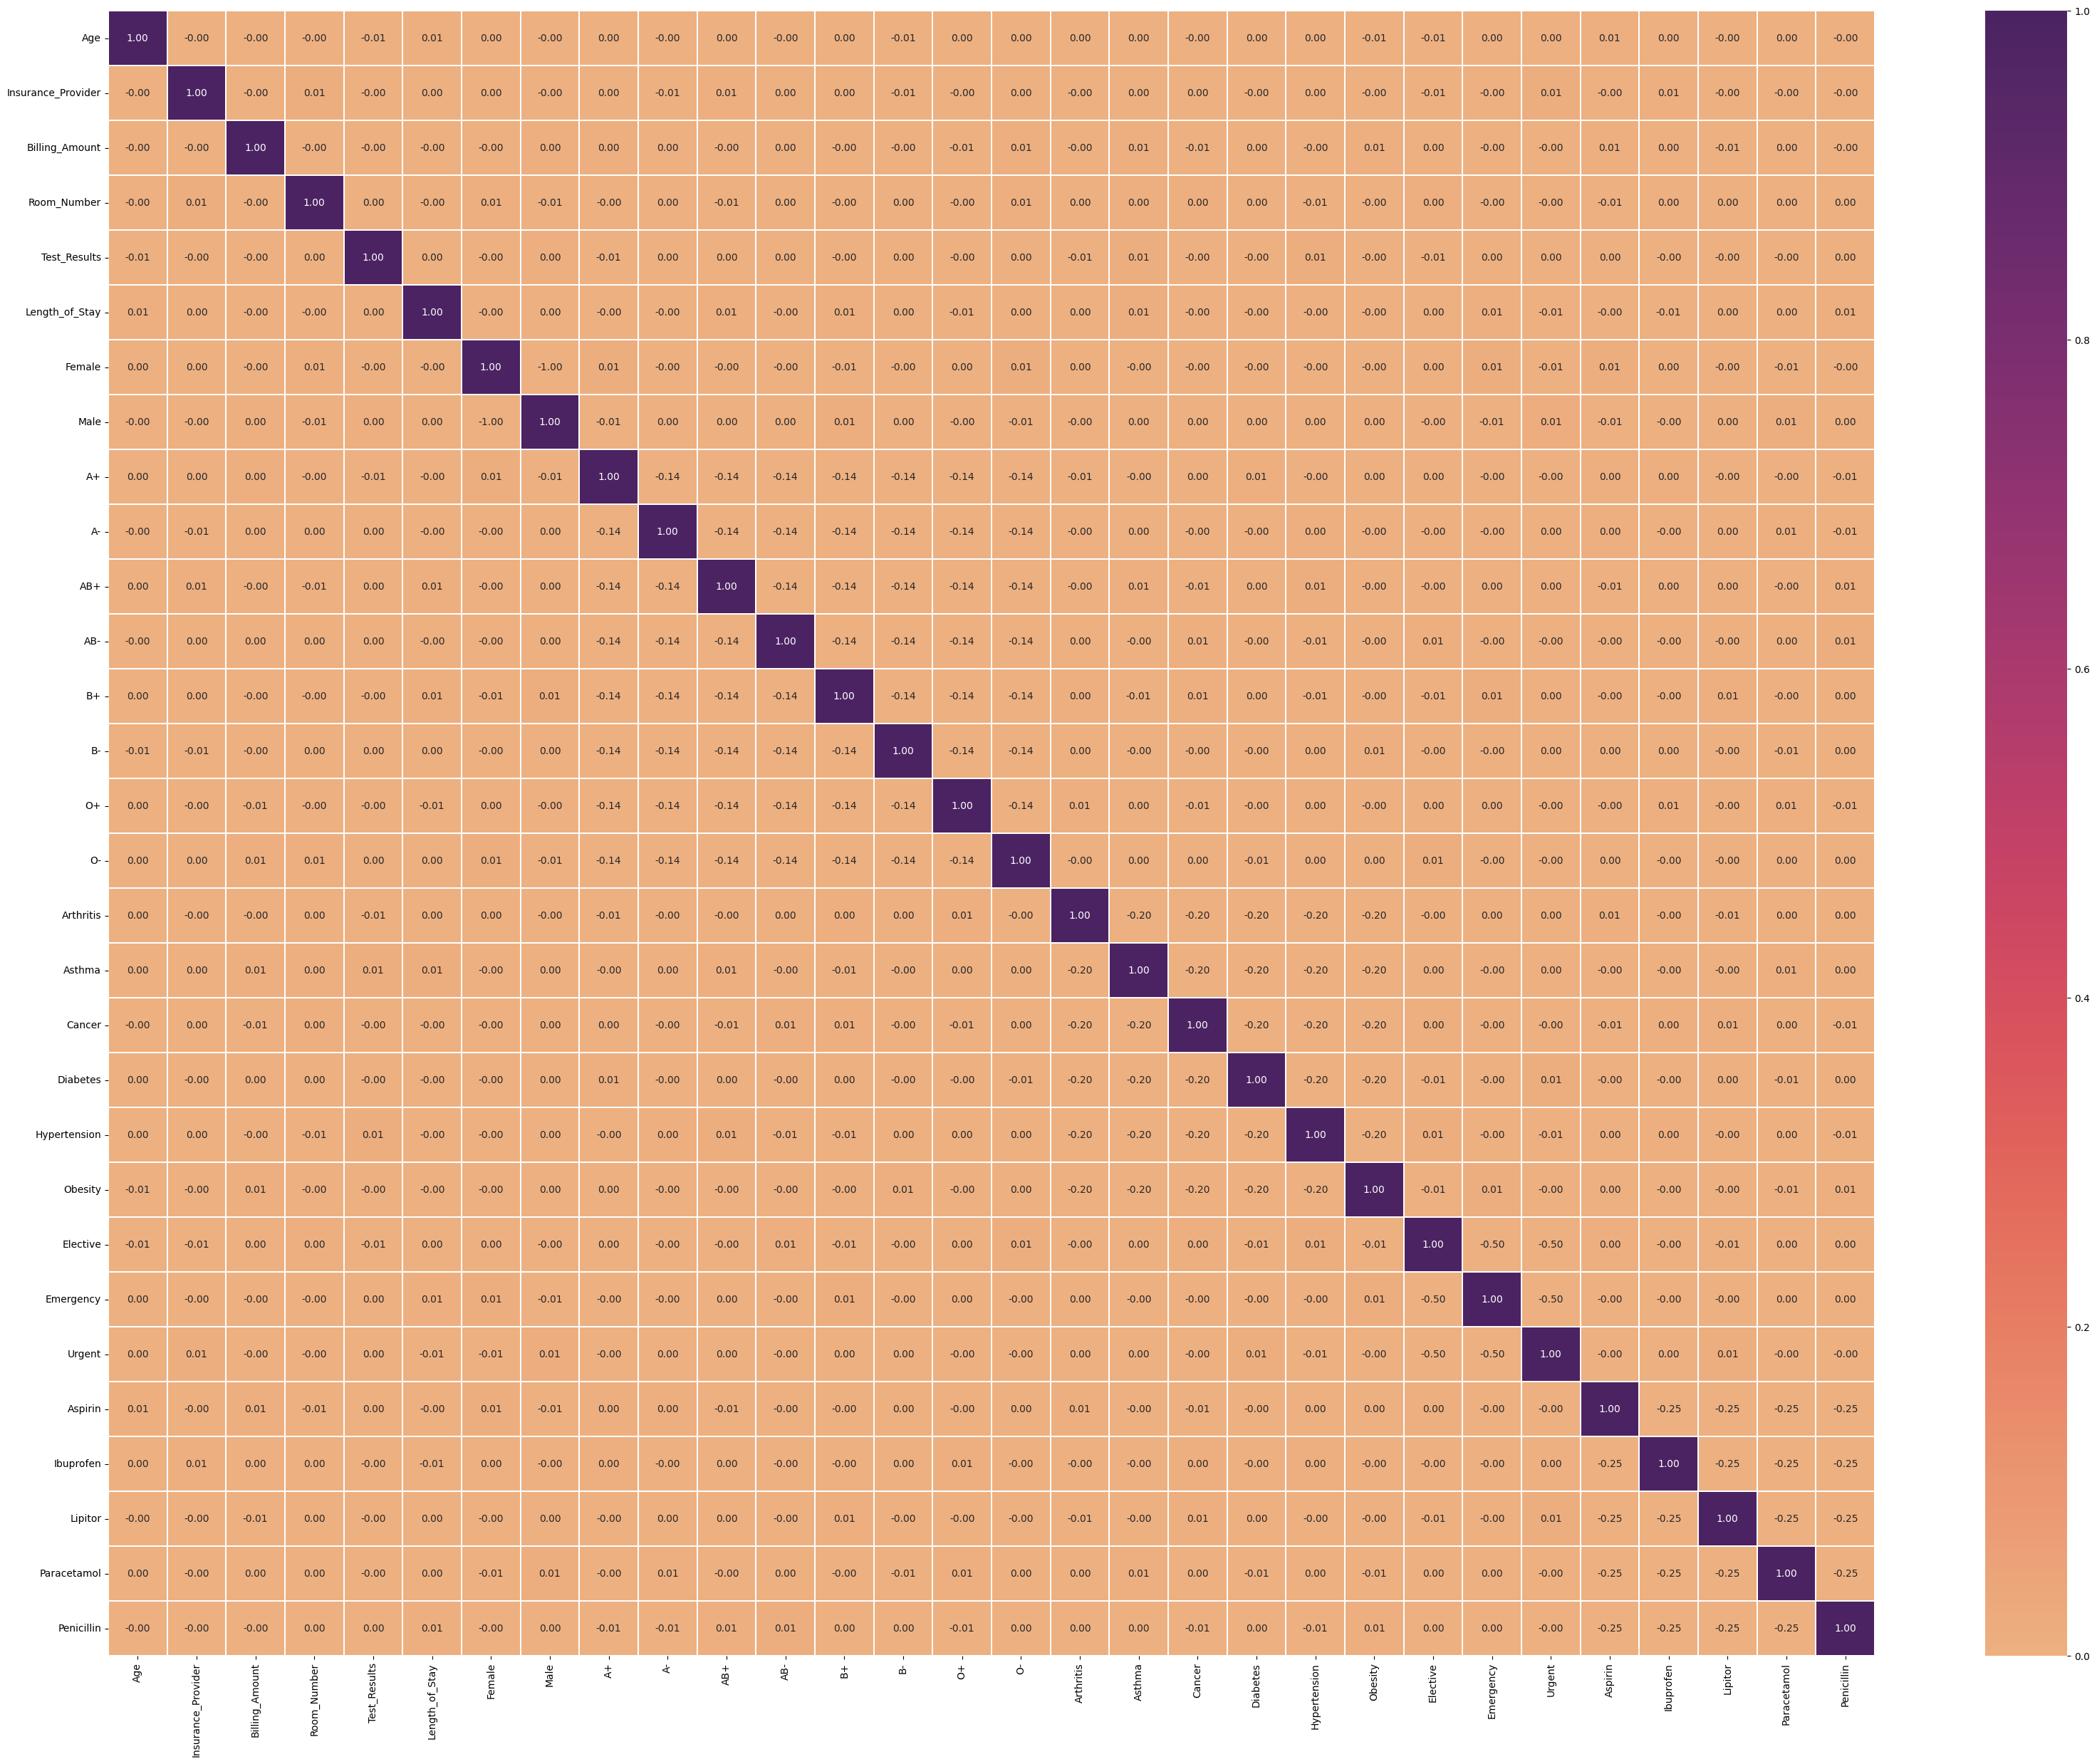

In [37]:
plt.figure(figsize=(40,30))
corr = Cleaned_data.corr()
sns.heatmap(corr, annot=True, linewidth=.1, vmin=0, vmax=1,
            fmt=".2f", cmap=sns.color_palette("flare", as_cmap=True))
plt.show()

## Principal Component Analysis (PCA)

In [42]:
Cleaned_data = Cleaned_data.sample(n=200, random_state=42)
Cleaned_data['Test_Results'] = data['Test Results']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(Cleaned_data.drop(columns='Test_Results'))

features = pd.DataFrame(scaled_data, columns=Cleaned_data.drop(columns='Test_Results').columns)

pca = PCA(random_state=42)
pca_data = pca.fit_transform(features)
pca_data

array([[ 1.29827992e+00,  2.26390962e+00, -4.62306820e-01, ...,
        -1.05946766e-15,  7.35691466e-16, -2.86754322e-16],
       [-2.10500813e+00,  2.40119380e-01,  1.00551872e+00, ...,
        -5.70505851e-17,  8.01150610e-17, -1.00181611e-16],
       [ 6.34972811e-01,  9.83742659e-02,  2.85964915e+00, ...,
         7.17362406e-16, -3.88326865e-16, -1.69692071e-16],
       ...,
       [-1.34879647e+00, -2.85609660e+00, -3.43058212e-01, ...,
         8.72125481e-17, -1.28924305e-16,  4.13658011e-17],
       [-2.24948315e+00,  1.61733642e-01,  5.47458101e-01, ...,
         2.37482628e-16, -3.89356044e-17,  4.04933227e-16],
       [-2.34265070e+00,  1.49660642e+00, -2.79675362e-01, ...,
         2.54566208e-16,  7.39919925e-17,  4.81582646e-17]])

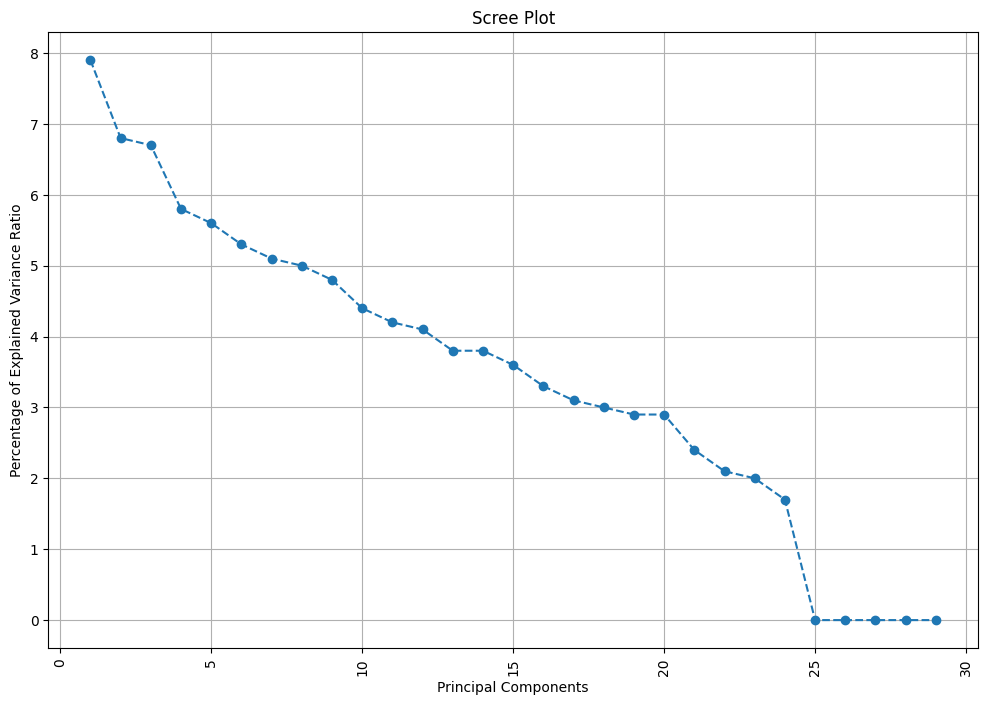

In [43]:
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var) + 1)]

plt.figure(figsize=(12,8))
plt.plot(range(1, len(per_var)+1), per_var, marker = 'o', linestyle='--')

plt.grid(True)
plt.ylabel('Percentage of Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.xticks(rotation=90)
plt.show()

## Multi Model Test & Evaluation

In [40]:
Cleaned_data = Cleaned_data.sample(n=200, random_state=42)
Cleaned_data['Test_Results'] = data['Test Results']

In [44]:
pca_data_df = pd.DataFrame(pca_data, columns=labels)
y = Cleaned_data['Test_Results']
X_train, X_test, y_train, y_test = train_test_split(pca_data_df, y, test_size=0.2, random_state=42)

Classifier: LogisticRegression
Accuracy: 25.00
              precision    recall  f1-score   support

    Abnormal       0.00      0.00      0.00        10
Inconclusive       0.36      0.29      0.32        17
      Normal       0.33      0.38      0.36        13

    accuracy                           0.25        40
   macro avg       0.23      0.23      0.23        40
weighted avg       0.26      0.25      0.25        40



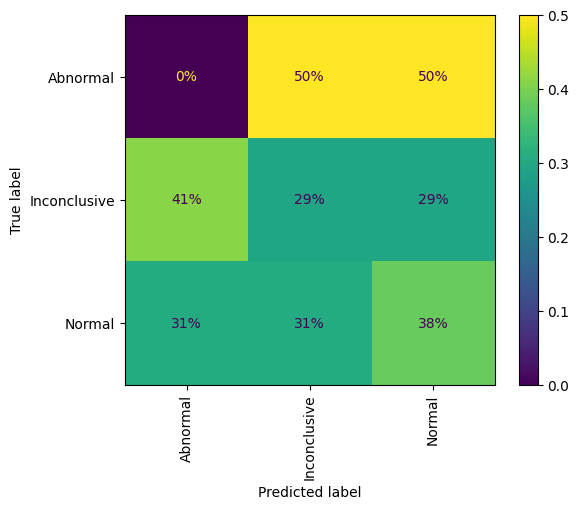

----------------------------------------------------------------------------------------------------
Classifier: SVC
Accuracy: 27.50
              precision    recall  f1-score   support

    Abnormal       0.08      0.10      0.09        10
Inconclusive       0.38      0.29      0.33        17
      Normal       0.33      0.38      0.36        13

    accuracy                           0.28        40
   macro avg       0.27      0.26      0.26        40
weighted avg       0.29      0.28      0.28        40



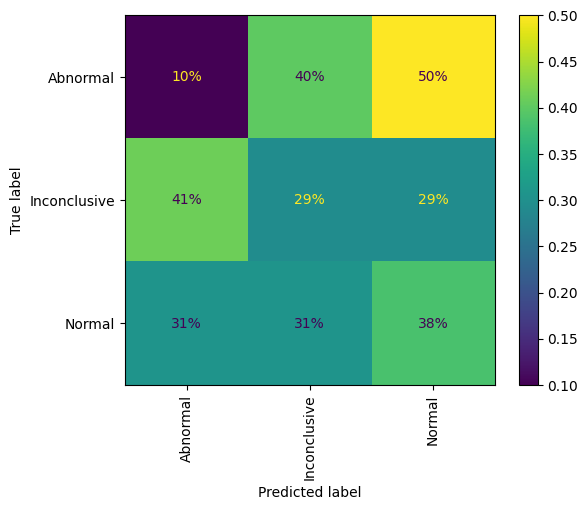

----------------------------------------------------------------------------------------------------
Classifier: RandomForestClassifier
Accuracy: 30.00
              precision    recall  f1-score   support

    Abnormal       0.09      0.10      0.10        10
Inconclusive       0.38      0.35      0.36        17
      Normal       0.38      0.38      0.38        13

    accuracy                           0.30        40
   macro avg       0.28      0.28      0.28        40
weighted avg       0.31      0.30      0.30        40



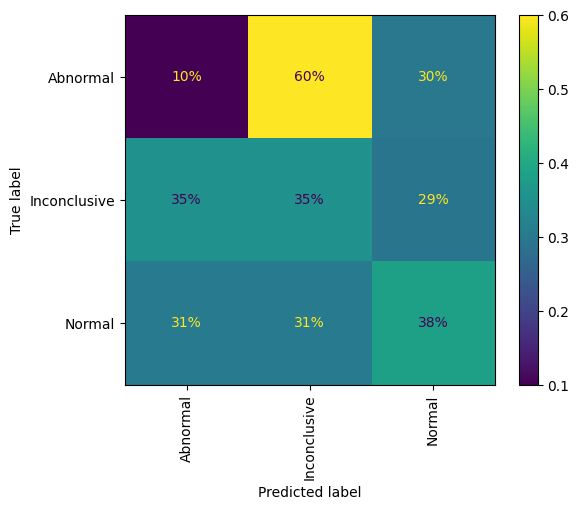

----------------------------------------------------------------------------------------------------
Classifier: DecisionTreeClassifier
Accuracy: 22.50
              precision    recall  f1-score   support

    Abnormal       0.00      0.00      0.00        10
Inconclusive       0.44      0.24      0.31        17
      Normal       0.24      0.38      0.29        13

    accuracy                           0.23        40
   macro avg       0.23      0.21      0.20        40
weighted avg       0.27      0.23      0.23        40



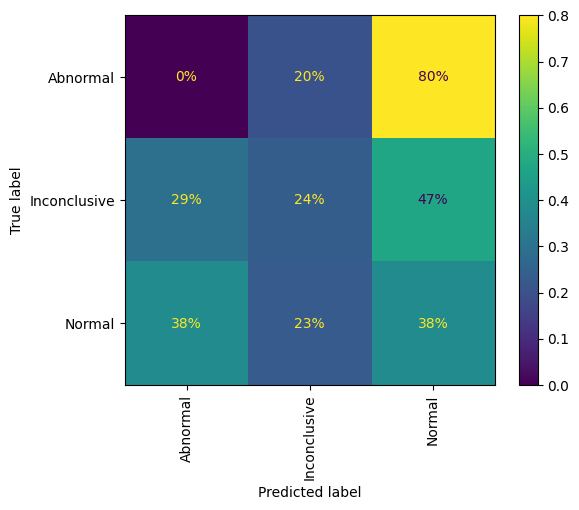

----------------------------------------------------------------------------------------------------


In [48]:
classifiers = [
    LogisticRegression(),
    SVC(kernel='linear'),
    RandomForestClassifier(),
    DecisionTreeClassifier(),
]

for clf in classifiers:

    model = make_pipeline(StandardScaler(), clf)
    
    model.fit(X_train.iloc[:, 0:15], y_train)
    
    y_pred = model.predict(X_test.iloc[:, 0:15])

    print(f'Classifier: {clf.__class__.__name__}')
    print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)*100:,.2f}')
    print(metrics.classification_report(y_test, y_pred))
    metrics.ConfusionMatrixDisplay.from_predictions(y_test,
                                                y_pred,
                                                normalize='true',
                                                values_format=".0%",
                                                xticks_rotation='vertical')
    plt.show()
    print('-' * 100)

## Hyperparameter Tunning Models

In [609]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns, index=X_test.index)

folds = KFold(n_splits=3, shuffle=True, random_state=42)

In [610]:

svc_model = SVC()
svc_model.fit(X_train_scaled, y_train)

params = {'C': [0.1, 1, 10, 100, 1000, 10000, 20000],
          'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

grid_search = GridSearchCV(
    estimator=svc_model,
    param_grid=params,
    scoring='f1_macro',
    cv=folds,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search.fit(X_train_scaled, y_train)
results = pd.DataFrame(grid_search.cv_results_)

print(f"Best params for : {grid_search.best_params_}")
print(f"Best score for : {grid_search.best_score_}")

Fitting 3 folds for each of 35 candidates, totalling 105 fits
Best params for : {'C': 20000, 'gamma': 0.0001}
Best score for : 0.3744349990266505


In [611]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled, y_train)

params = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        
    }
    
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=params,
    scoring='f1_macro',
    cv=folds,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search.fit(X_train_scaled, y_train)
results = pd.DataFrame(grid_search.cv_results_)

print(f"Best params for: {grid_search.best_params_}")
print(f"Best score for: {grid_search.best_score_}")

Fitting 3 folds for each of 225 candidates, totalling 675 fits
Best params for: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best score for: 0.3992206447541604


In [612]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_scaled, y_train)

params = {
        'max_depth': [None, 10, 20, 30, 40, 50],
        'min_samples_split': [2, 5, 10, 15, 20],
        'min_samples_leaf': [1, 2, 4, 6, 8],
    }

grid_search = GridSearchCV(
        estimator=dt_model,
        param_grid=params,
        scoring='f1_macro',
        cv=folds,
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )
    
grid_search.fit(X_train_scaled, y_train)
results = pd.DataFrame(grid_search.cv_results_)

print(f"Best params for: {grid_search.best_params_}")
print(f"Best score for: {grid_search.best_score_}")

Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best params for: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best score for: 0.3352559390510055
